In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw12.ipynb")

# Homework 12: Classification

**Author**: Yanay Rosen

**Helpful Resource:**
- [Python Reference](http://data8.org/su21/python-reference.html): Cheat sheet of helpful array & table methods used in Data 8!

**Reading**: 
* [Classification](https://www.inferentialthinking.com/chapters/17/Classification.html)

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the provided tests. Each time you start your server, you will need to execute this cell again to load the tests.

For all problems that you must write explanations and sentences for, you **must** provide your answer in the designated space. **Moreover, throughout this homework and all future ones, please be sure to not re-assign variables throughout the notebook!** For example, if you use `max_temperature` in your answer to one question, do not reassign it later on. Otherwise, you will fail tests that you thought you were passing previously!

**Deadline:**

This assignment is due Friday, August 6 at 11:59 P.M. PDT. Late work will not be accepted as per the [policies](http://data8.org/su21/policies.html) page.

**Note: This homework has hidden tests on it. That means even though tests may say 100% passed, doesn't mean your final grade will be 100%. We will be running more tests for correctness once everyone turns in the homework.**

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Refer to the policies page to learn more about how to learn cooperatively.

You should start early so that you have time to get help if you're stuck. Office hours are held Monday-Friday. The schedule appears on [http://data8.org/su21/office-hours.html](http://data8.org/su21/office-hours.html).

In [2]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *

# These lines do some fancy plotting magic.",
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## Bay Area School Coordinates with Classification

Welcome to Homework 12! This homework is about k-Nearest Neighbors classification (kNN). Since this topic is covered in depth in Project 3, the purpose of this homework is to reinforce the basics of this method. You can and should reuse a lot of code that you wrote for Project 3 for this homework, or use code from this homework on Project 3!

## Our Dearest Neighbors

Carol is trying classify students as either attendees of UC Berkeley or as attendees of Stanford University. To classify the students, Carol has access to the coordinates of the location they live during the school year. First, load in the `coordinates` table.

In [3]:
# Just run this cell!
coordinates = Table.read_table('coordinates.csv')
coordinates.show(5)

latitude,longitude,school
37.8693,-122.255,Berkeley
37.8651,-122.256,Berkeley
37.8661,-122.254,Berkeley
37.868,-122.26,Berkeley
37.8683,-122.257,Berkeley


As usual, let's investigate our data visually before performing any kind of numerical analysis.

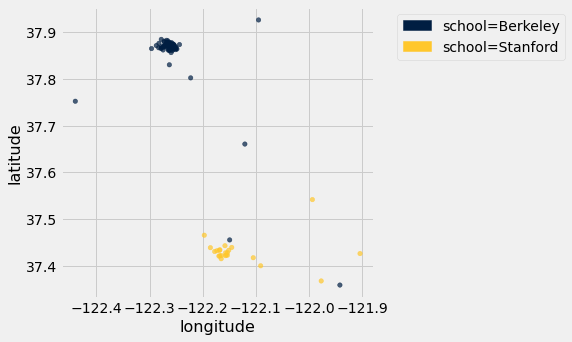

In [4]:
# Just run this cell!
coordinates.scatter("longitude", "latitude", group="school")

The locations of the points on this scatter plot might be familiar - run the following cell to see what they correspond to.

In [5]:
# Just run this cell!
colors = {"Berkeley":"blue", "Stanford":"red"}
t = Table().with_columns("lat", coordinates.column(0), 
                                      "lon", coordinates.column(1), 
                                      "color", coordinates.apply(colors.get, 2)
                        )
Circle.map_table(t, radius=5, fill_opacity=1)

#### Question 1

Let's begin implementing the k-Nearest Neighbors algorithm. Define the `distance` function, which takes in two arguments: an array of numerical features (`arr1`), and a different array of numerical features (`arr2`). The function should return the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the two arrays. Euclidean distance is often referred to as the straight-line distance formula that you may have learned previously. **(5 points)**


<!--
BEGIN QUESTION
name: q1_1
manual: false
points:
 - 0
 - 5
-->

In [6]:
def distance(arr1, arr2):
    '''Same as c = sqrt((a1 - a0)^2 + (b1 - b0)^2)'''
    return np.sqrt(sum((arr1 - arr2)**2))

# Don't change/delete the code below in this cell
distance_example = distance(make_array(1, 2, 3), make_array(4, 5, 6))
distance_example

5.196152422706632

In [7]:
grader.check("q1_1")

q1_1 results: All test cases passed!

### Splitting the dataset
We'll do 2 different kinds of things with the `coordinates` dataset:
1. We'll build a classifier using coordinates for which we know the associated label; this will teach it to recognize labels of similar coordinate values. This process is known as *training*.
2. We'll evaluate or *test* the accuracy of the classifier we build on data we haven't seen before.

For reasons discussed in lecture and the textbook, we want to use separate datasets for these two purposes.  So we split up our one dataset into two.

#### Question 2

Next, let's split our dataset into a training set and a test set. Since `coordinates` has $100$ rows, let's create a training set with the first 75 rows and a test set with the remaining 25 rows. Remember that assignment to each group should be random, so we should shuffle the table first.

*Hint: as a first step we can shuffle all the rows, then use the* `tbl.take` *function to split up the rows for each table*

**(15 points)**

<!--
BEGIN QUESTION
name: q1_2
manual: false
points:
 - 3
 - 3
 - 9
-->

In [8]:
shuffled_table = coordinates.sample(with_replacement=False)
train = shuffled_table.take(np.arange(75))
test = shuffled_table.take(np.arange(75, 100))

print("Training set:\t",   train.num_rows, "examples")
print("Test set:\t",       test.num_rows, "examples")
train.show(5), test.show(5);

Training set:	 75 examples
Test set:	 25 examples


latitude,longitude,school
37.9261,-122.095,Berkeley
37.8688,-122.255,Berkeley
37.6605,-122.121,Berkeley
37.7521,-122.44,Berkeley
37.8813,-122.265,Berkeley


latitude,longitude,school
37.8729,-122.254,Berkeley
37.8668,-122.257,Berkeley
37.4552,-122.149,Berkeley
37.8619,-122.274,Berkeley
37.8659,-122.278,Berkeley


In [9]:
grader.check("q1_2")

q1_2 results: All test cases passed!

#### Question 3

Assign `features` to an array of column names (strings) of the features from the `coordinates` table.

*Hint: which of the column names in the `coordinates` table are the features, and which of the column names correspond to the class we're trying to predict?*

**(5 points)**

<!--
BEGIN QUESTION
name: q1_3
manual: false
points:
 - 5
-->

In [10]:
features = coordinates.drop("school").labels
features

('latitude', 'longitude')

In [11]:
grader.check("q1_3")

q1_3 results: All test cases passed!

<div class="hide">\pagebreak</div>

#### Question 4

Now define the `classify` function. This function should take in a `test_row` from a table like `test` and classify it based on the data in `train` using the `k`-Nearest Neighbors based on the correct `features`.

*Hint: The `distance` function we defined earlier takes in arrays as input, so use the `row_to_array` function we defined for you to convert rows to arrays of features.*

*Hint 2: the skeleton code we provided iterates through each row in the training set*

**(15 points)**

A refresher on k-nearest neighbors can be found [here](https://www.inferentialthinking.com/chapters/17/4/Implementing_the_Classifier.html) in the textbook.

<!--
BEGIN QUESTION
name: q1_4
manual: false
points:
 - 0
 - 15
-->

In [12]:
def row_to_array(row, features):
    arr = make_array()
    for feature in features:
        arr = np.append(arr, row.item(feature))
    return arr

def classify(test_row, k, train):
    test_row_features_array = row_to_array(test_row, features)
    distances = make_array()
    for train_row in train.rows:
        train_row_features_array = row_to_array(train_row, features)
        row_distance = distance(train_row_features_array, test_row_features_array)
        distances = np.append(distances, row_distance)
    train_with_distances = train.with_columns("distance to test", distances)
    nearest_neighbors = train_with_distances.sort("distance to test").take(np.arange(k))
    most_common_label = nearest_neighbors.group("school").column("school").item(0)
    return most_common_label

# Don't modify/delete the code below
first_test = classify(test.row(0), 5, train)
first_test

'Berkeley'

In [13]:
grader.check("q1_4")

q1_4 results: All test cases passed!

<div class="hide">\pagebreak</div>

#### Question 5

Define the function `three_classify` that takes a `row` from `test` as an argument and classifies the row based on using 3-Nearest Neighbors. Use this function to find the `accuracy` of a 3-NN classifier on the `test` set. `accuracy` should be a proportion (not a percentage) of the schools that were correctly predicted.

*Hint: you should be using a function you just created!*

*Note: Usually before using a classifier on a test set, we'd classify first on a "validation" set, which we then can modify our training set again if need be, before actually testing on the test set. You don’t need to do that for this question, but you will learn about this more in Data 100.*

**(20 points)**

<!--
BEGIN QUESTION
name: q1_5
manual: false
points:
 - 10
 - 10
-->

In [14]:
def three_classify(row):
    return classify(row, 3, train)

test_with_prediction = test.with_column("prediction", test.apply(three_classify))
labels_correct = test_with_prediction.column("school") == test_with_prediction.column("prediction")
accuracy = np.count_nonzero(labels_correct) / len(labels_correct)
accuracy

0.92

In [15]:
grader.check("q1_5")

q1_5 results: All test cases passed!

#### Question 6

There are 77 rows of Berkeley students and 23 rows of Stanford students in the `coordinates` table. If we used the entire `coordinates` table as the train set, what is the smallest value of k that would ensure that a k-Nearest Neighbor classifier would always predict Berkeley as the class? Assign the value to `k`. **(12 points)**

<!--
BEGIN QUESTION
name: q1_6
manual: false
points:
 - 0
 - 12
-->

In [17]:
k = 23 * 2 + 1
k

47

In [18]:
grader.check("q1_6")

q1_6 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 7

Why do we divide our data into a training and test set? What is the point of a test set, and why do we only want to use the test set once? Explain your answer in 3 sentences or less. 

*Tip: check out this [section](https://inferentialthinking.com/chapters/17/2/Training_and_Testing.html) in the textbook*

**(8 points)**

<!--
BEGIN QUESTION
name: q1_7
manual: true
-->

_We divide our data into training set in order to help our model learn to classify. The point of test set is to see how well our model performs on unseen data. We only want to use test set once because we want to measure accuracy on unseen data. If we use it multiple times then that becomes seen data which is considered training set._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Question 8

Why do we use an odd-numbered `k` in k-NN? Explain. **(5 points)**


<!--
BEGIN QUESTION
name: q1_8
manual: true
-->

_We use an odd-numbered k in k-NN to avoid further calculation that arise when there is a tie. When there is a odd number k one category is always at least one more than the other category._

<!-- END QUESTION -->

#### Question 9

Thomas has devised a scheme for splitting up the test and training set. For each row from `coordinates`:

- Rows for Stanford students have a 50% chance of being placed in the train set and 50% chance of placed in the test set.

- Rows for Berkeley students have a 80% chance of being placed in the train set and 20% chance of placed in the test set.


Given that a row is in the test set, what is the probability that it corresponds to a Stanford student? Assign that probability to `prob_furd`.

*Hint: Remember that there are 77 Berkeley students and 23 Stanford students in `coordinates`*

*Hint 2: Thomas' last name is Bayes*

**(15 points)**

<!--
BEGIN QUESTION
name: q1_9
manual: false
points:
 - 0
 - 0
 - 15
-->

In [19]:
# stanford train set: 50 % of 23 = 11.5
# stanford test set: 50 % of 23 = 11.5
# berkeley train set: 80 % of 77 = 61.6
# berkeley test set: 20 % of 77 = 15.4
# total = 100
# test set = 11.5 + 15.4 = 26.9

In [20]:
prob_furd = 11.5 / 26.9
prob_furd

0.42750929368029744

In [21]:
grader.check("q1_9")

q1_9 results: All test cases passed!

Congrats, you've finished the last homework! Be sure to scroll down to complete the final feedback survey and the official Berkeley course evaluations form that you will receive via email. If 80% of the class fills out both surveys, everyone will receive 2 bonus points on the final exam.

## (OPTIONAL, NOT IN SCOPE): k-NN for Non-Binary Classification

**THIS IS NOT IN SCOPE/IS OPTIONAL**. There are no autograder tests for this/code for you to write. It just relies on the function `classify` in Question 4.

In this class, we have taught you how to use the kNN algorithm to classify data as one of two classes. However, much of the data you will encounter in the real world will not fall nicely into one of two categories. 

How can we classify data with non-binary classes? It turns out we can still use kNN! That is, we find the distance between a point and all its neighbors, find the nearest neighbors, and take a majority vote among the neighbors to determine this point's class. 

The only difference is that now the neighboring points have more than two possible classes. This does introduce difficulty because now we have no way of guaranteeing that we will not encounter ties between classes. In the case that we do encounter a tie, we can just arbitrarily choose one of the classes.

In fact, you don't even have to modify the code you wrote before at all to enable multi-class classification!

Let's add some more data to our train table, this time for another class of students, students at San Jose Community College (SJCC).

In [22]:
coordinates_multi = coordinates.with_rows([
                              [37.304346, -121.915401, "SJCC"],
                              [37.316275, -121.913879, "SJCC"],
                              [37.409435, -121.951379, "SJCC"],
                              [37.349387, -121.960771, "SJCC"],
                              [37.329083, -121.928479, "SJCC"],
                              [37.313017, -121.866730, "SJCC"],
                              [37.346525, -121.894767, "SJCC"],
                              [37.364157, -121.955717, "SJCC"],
                              [37.383362, -121.925776, "SJCC"],
                              [37.329545, -121.880639, "SJCC"]                             
])

In [23]:
classify(coordinates_multi.row(0), 5, coordinates_multi)

'Berkeley'

In [24]:
classify(coordinates_multi.row(91), 5, coordinates_multi)

'Stanford'

In [25]:
classify(coordinates_multi.row(105), 5, coordinates_multi)

'SJCC'

Our classifier can classify rows as belonging to one of three classes!

Classification is one of the most important fields in statistics, data science, and machine learning. There are thousands of different classification algorithms and modifications of algorithms! There are many that you'll learn if you continue down the path of becoming a data scientist!

## 2. Final-Semester Survey


You can find the end of semester feedback form [here](https://docs.google.com/forms/d/e/1FAIpQLSeoqs0gSpe6N3kiBRrSgq2ey2nF98cA8eUud0nPqviq8Y4MLQ/viewform?usp=sf_link). Please take some time to fill the survey out! Data 8 is still a relatively new class, and your feedback helps the class get better every semester!

As incentive, if 80% of the course fills out this feedback form **and** the official Berkeley Course Evaluations (you should receive an email soon) for Data 8, everyone will receive two points of extra credit on the final!

**Question 1.** Fill out the end of semester feedback form linked above. Once you have submitted, a secret word will be displayed. Set `secret_word` to the secret string at the end of the form.

<!--
BEGIN QUESTION
name: q2_1
manual: false
-->

In [26]:
secret_word = "readyforfall"

In [27]:
grader.check("q2_1")

q2_1 results: All test cases passed!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [28]:
grader.check_all()

q1_1 results: All test cases passed!

q1_2 results: All test cases passed!

q1_3 results: All test cases passed!

q1_4 results: All test cases passed!

q1_5 results: All test cases passed!

q1_6 results: All test cases passed!

q1_9 results: All test cases passed!

q2_1 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [29]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)